In [1]:
## Imports

## Main Code
# We will use the feature_handler class to extract features from the point clouds
from blobBgone.featureHandler import featureHandler

## MISC
import os
import numpy as np

In [2]:
## Pease, enter your favorite number between between 0 and 500 (for this example)
# We will use this number to select a point cloud from the dataset
number = 11

In [3]:
## Grab the files
# We use the static built-in grab_files method to grab the files from the current directory
# This method returns a list of all the files in the current directory that end with .npy

# If you are on Windows, you can leave the path argument as None to automatically call the explorer

files = featureHandler.grab_files(path = None)

print(f"Found {len(files)} files in the '{files[0].split(os.sep)[-2]}' directory.")

Found 500 files in the 'C:/Users/belav/Documents/GitHub/blob-B-gone/Example_Data/Simulation/2D_Mix_dynamicSTD' directory.


Feature Handler (ID = 261, dimension = 2, length = 595)

Features in place.
 - None
 
      -------------------------------------- 

 - To get an array of features call featureHandler.to_array()
 - To get a dict of features call featureHandler.to_dict()

 -------------------------------------------------------- 

The Id of the track chosen belongs to the blob category.
Let's check the track to verify this:


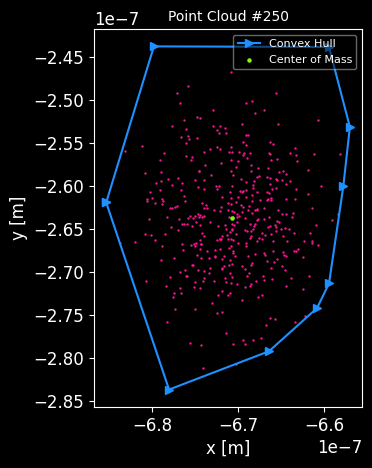

Looks like a blob to me!


In [4]:
## Setup the task list
# We will use the task list to keep track of the files that have been processed
# Each feature handler is designed to handle one point cloud at a time for flexibility

task_list = [featureHandler.from_npy(path = file, verbose = False) for file in files]

limit_gen = np.random.Generator(np.random.PCG64(42))
## Reshape the point clouds
for task in task_list:
    limiter = limit_gen.integers(low = 400, high = 600, size = 1)[0]
    task.pointCloud = task.pointCloud[:limiter]

# Get a quick look at the first file
print(task_list[number])

# We notice that the point cloud dimension is automatically detected and the ID extracted from the file name
# In this example, the IDs are used to identify if the track is a blob or not
# Reference:
#   - ID in [0,249] -> freely diffusing marker
#   - ID in [250,499] -> blob (artifactual marker)

free_ID = range(0,250)
blob_ID = range(250,500)

print("\n -------------------------------------------------------- \n")
print(f"The Id of the track chosen belongs to the {'blob' if task_list[number].ID in blob_ID else 'freely diffusing marker'} category.")
print("Let's check the track to verify this:")

task_list[0].overview()

print(f"Looks like a {'blob' if task_list[number].ID in blob_ID else 'freely diffusing marker'} to me!")

In [5]:
## Featre extraction
# Now that we have everythin gin place, we can extract the features from the point clouds
# We will use the feature_handler class to extract the features from the point clouds by calling the extract() method

features = []
for task in task_list:
    task.extract()
    features.append(task.to_array())
    
# Let's check the features extracted from the our favorite point cloud
print(task_list[number])
    
# In order to effectively use the features during clustering, we need to transform all of them to the same scale/distribution
# Otherwise, the clustering algorithm will be biased towards the features with the largest scale/distribution
method:str = 'standardize' # or 'force_raw
features = featureHandler.regularize_output(features, method = method)
assert np.all(np.isfinite(features)), "NaN values still present in features."

Feature Handler (ID = 261, dimension = 2, length = 595)

Features in place.
 - features2D(MAX_DIST=4.549941503542966e-08, CV_AREA=1.1751336564257615e-15, SPHE=5.809679315859678, ELLI=1.0245636962367333, CV_DENSITY=5.0632538413522054e+17)
 
      -------------------------------------- 

 - To get an array of features call featureHandler.to_array()
 - To get a dict of features call featureHandler.to_dict()


In [6]:
## Clustering ##
# Now here is where the magic happens. We use the KMeans algorithm to cluster the features.
# The number of clusters is set to 2, as we want to separate blobs from the freely diffusing markers
from sklearn.cluster import KMeans

n_cluster = 2

# The default is 'auto', which automatically chooses a value based on the number of features.
n_init = 'auto'

# The 'max_iter' parameter determines how many iterations the algorithm will run before it stops.
max_iter = 300

# Seed the random number generator for reproducibility using the 'random_state' flag.
# For all examples in this notebook, we will keep the seed as 42.
random_state = 42

# Instantiate the KMeans clustering algorithm
clustering_FH  = KMeans(
    n_clusters = n_cluster,
    init = 'k-means++',
    n_init = n_init,
    max_iter = max_iter,
    verbose = 0,
    random_state = random_state,
    )

## Fit the clustering algorithm to the features ##
# In our application we attempt a single shot application of the algorithm, i.e. we do not train the algorithm on a subset of the data and then test it on the rest.
# This has the advantage that we do not need to split the data into training and test sets, which is a problem in our case since we do not have a lot of data.
# We forego time intensive labelling and instead use the clustering algorithm to find similar features.

fit_predict_FH = clustering_FH.fit_predict(features)

------------------------------

Cluster 1: 251 tasks
Cluster 2: 249 tasks

Cluster1
Low_end_ID: 119
High_end_ID: 499

Cluster2
Low_end_ID: 0
High_end_ID: 249

------------------------------

Track Mismatches:[119]

Blob Mismatches:[]

Total number of mismatches: 1

------------------------------

Accuracy: 0.998
F1 Score: 0.997999991999968
Homogeneity: 0.981
Completeness: 0.981
V-measure: 0.981
Adjusted Rand Index: 0.992
Adjusted Mutual Information: 0.981
Silhouette Coefficient: 0.706

------------------------------



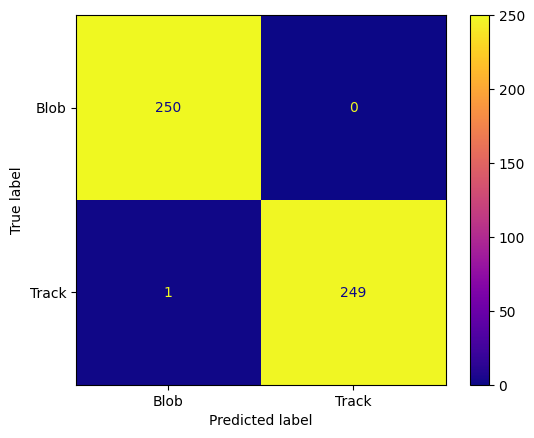

In [7]:
from sklearn import metrics

cluster_1 = [task_list[i] for i in range(len(task_list)) if fit_predict_FH[i] == 0]
cluster_2 = [task_list[i] for i in range(len(task_list)) if fit_predict_FH[i] == 1]

print("------------------------------\n")

print('Cluster 1: {} tasks'.format(len(cluster_1)))
print('Cluster 2: {} tasks'.format(len(cluster_2)))

print(f"\nCluster1\nLow_end_ID: {min([task.ID for task in cluster_1])}\nHigh_end_ID: {max([task.ID for task in cluster_1])}")
print(f"\nCluster2\nLow_end_ID: {min([task.ID for task in cluster_2])}\nHigh_end_ID: {max([task.ID for task in cluster_2])}")

print("\n------------------------------\n")
print(f"Track Mismatches:{[task.ID for task in cluster_1 if task.ID not in blob_ID]}")
print(f"\nBlob Mismatches:{[task.ID for task in cluster_2 if task.ID not in free_ID]}")

print(f"\nTotal number of mismatches: {len([task.ID for task in cluster_1 if task.ID not in blob_ID]) + len([task.ID for task in cluster_2 if task.ID not in free_ID])}")

print("\n------------------------------\n")
print(f"Accuracy: {metrics.accuracy_score([0 for i in free_ID] + [1 for i in blob_ID], fit_predict_FH, normalize=True)}")
print(f"F1 Score: {metrics.f1_score([0 for i in free_ID] + [1 for i in blob_ID], fit_predict_FH, average='macro')}")

labels_true = [0 for i in free_ID] + [1 for i in blob_ID]
labels = fit_predict_FH

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(features, labels, metric="euclidean")
    )
print("\n------------------------------\n")


import matplotlib.pyplot as plt
plt.style.use('default')
cm = metrics.confusion_matrix(labels_true, fit_predict_FH, normalize=None)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blob', 'Track']).plot(cmap = 'plasma')

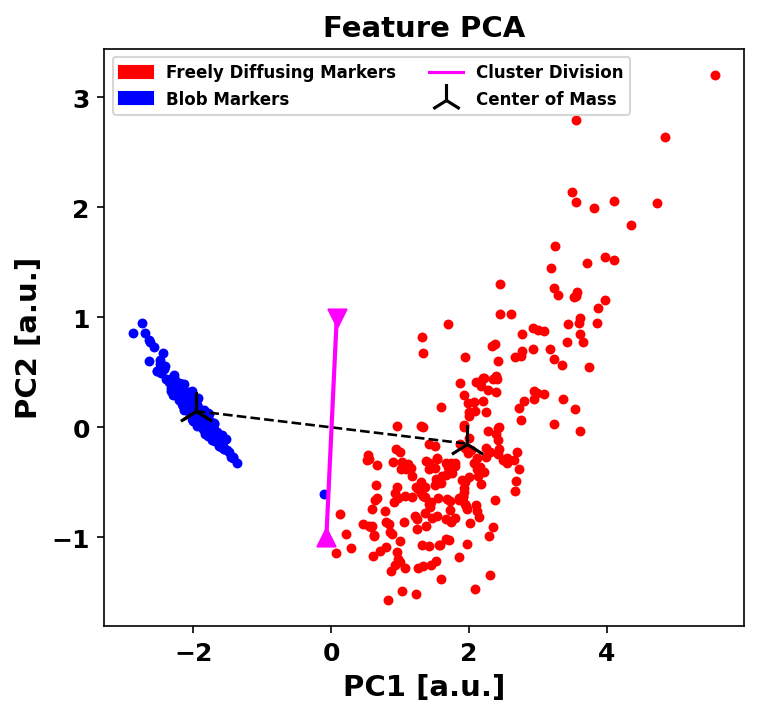

In [8]:
## Feature PCA ##
# To visualize the clustering results, we will use the PCA algorithm to reduce the dimensionality of the features to 2.
# We thus gain the bility to plot the agglomeration of the features in 2D space and highlight the decision boundary.

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from blobBgone.utils import Helper

plt.style.use('default')
pca = PCA(n_components=2)
trans= pca.fit_transform(features)

cluster_1_mean = np.mean(trans[fit_predict_FH == 0], axis = 0)
cluster_2_mean = np.mean(trans[fit_predict_FH == 1], axis = 0)
P1,P2 = Helper.generate_perpendicular_vector(cluster_1_mean, cluster_2_mean, scale = 1.0, direction = 'center')

plt.style.use('default')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(5.5,5), dpi = 150)
ax.scatter(trans[:,0][fit_predict_FH == 0], trans[:,1][fit_predict_FH == 0], c = 'blue', s = 14)
ax.scatter(trans[:,0][fit_predict_FH == 1], trans[:,1][fit_predict_FH == 1], c = 'red', s = 14)
ax.scatter(cluster_1_mean[0], cluster_1_mean[1], c = 'black', s = 350, marker = '2', label = 'Center of Mass')
ax.scatter(cluster_2_mean[0], cluster_2_mean[1], c = 'black', s = 350, marker = '2')
ax.plot([cluster_1_mean[0], cluster_2_mean[0]], [cluster_1_mean[1], cluster_2_mean[1]], '--', c = 'black', linewidth = 1.25)
ax.plot([P1.x, P2.x], [P1.y,P2.y], '-', c = 'magenta', linewidth = 2)
ax.scatter([P1.x], [P1.y], c = 'magenta', s = 75, marker = 'v')
ax.scatter([P2.x], [P2.y], c = 'magenta', s = 75, marker = '^')

ax.set_xlabel('PC1 [a.u.]', fontsize = 14, fontweight = 'bold')
ax.set_ylabel('PC2 [a.u.]', fontsize = 14, fontweight = 'bold')
ax.set_title('Feature PCA', fontsize = 14, fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='Freely Diffusing Markers')
blue_patch = mpatches.Patch(color='blue', label='Blob Markers')
Division = mlines.Line2D([P1.x, P2.x], [P1.y,P2.y],  linestyle = '-',c = 'magenta', label = 'Cluster Division')
CoM =  ax.scatter(cluster_1_mean[0], cluster_1_mean[1], c = 'black', s = 250, marker = '2', label = 'Center of Mass')


plt.legend(handles=[red_patch, blue_patch, Division, CoM], fontsize = 8, loc = 'upper left', ncol= 2)

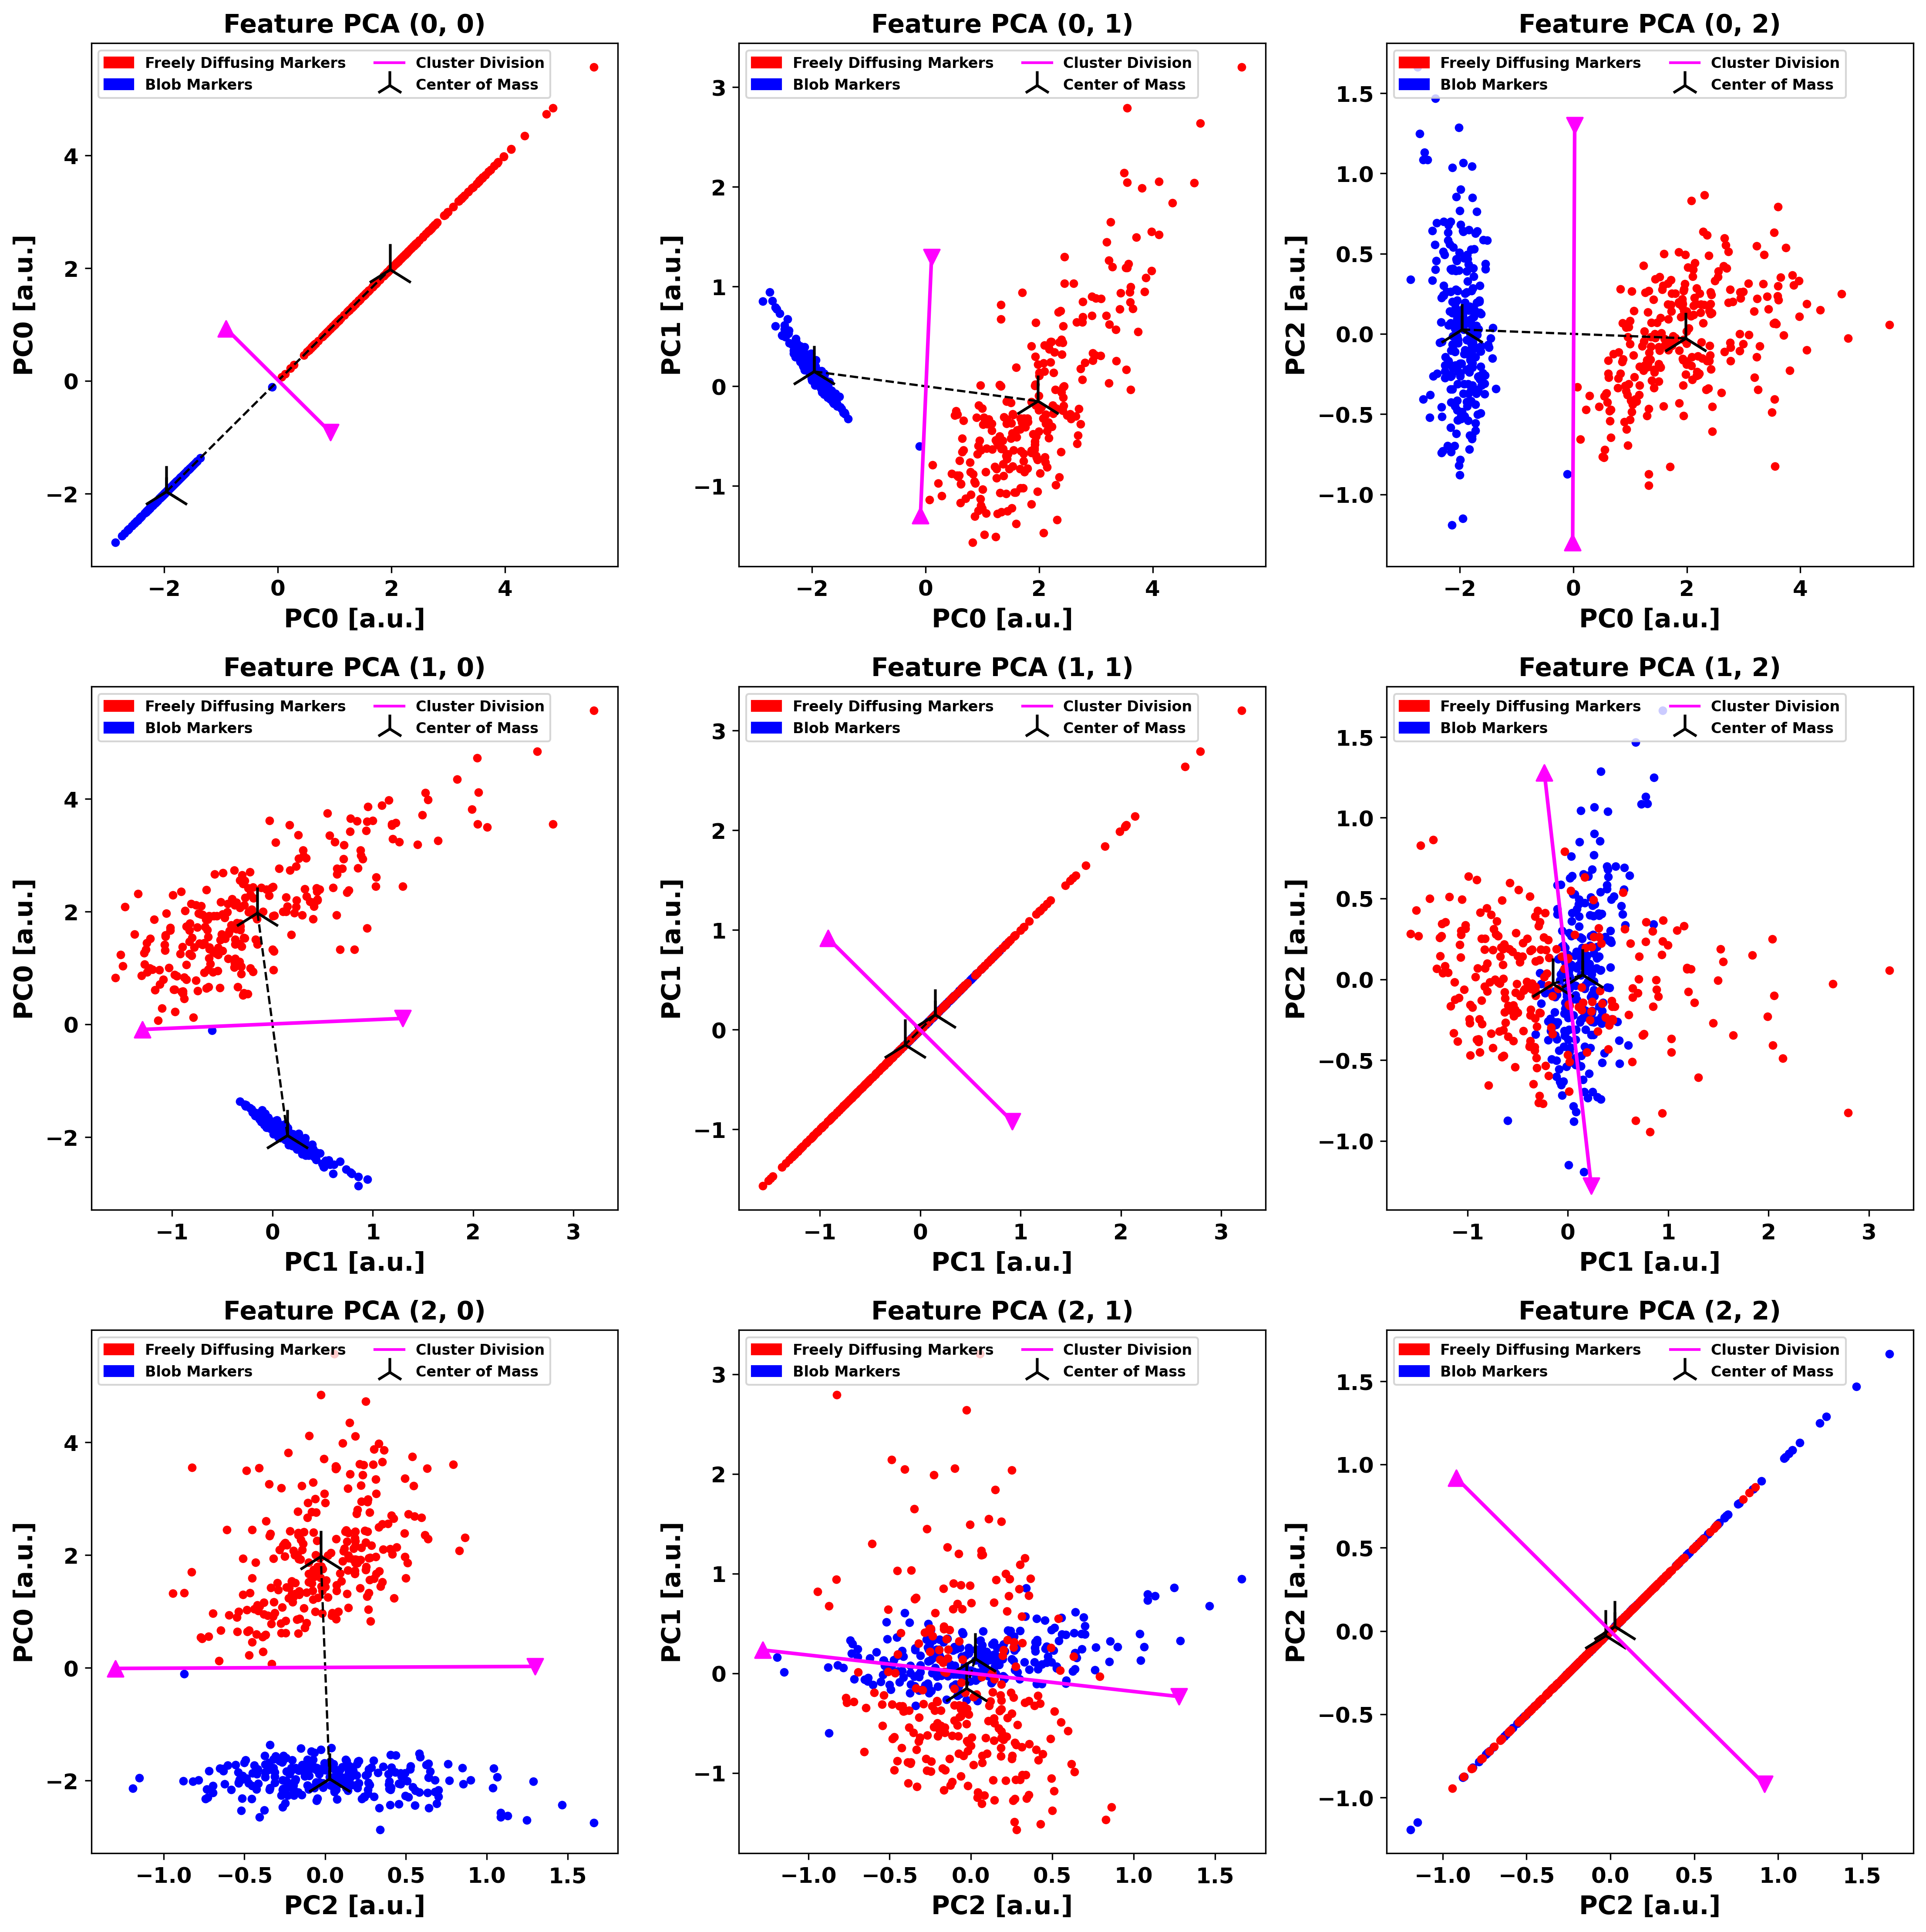

In [9]:
## Feature PCA 3 Components ##
# If we wish to further disect the features, we can use the PCA algorithm to reduce the dimensionality to only 3 components
# We thus gain a bit mroe insight into the features and how they are clustered, however, we have to keep in mind that the original feature space has only 5 dimensions
# Thus, we embrace more variance as compared to the reduction to 2 components.

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from blobBgone.utils import Helper

plt.style.use('default')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

n_components = 3

fig, axs = plt.subplots(n_components, n_components, figsize=(18,18), dpi = 300)
plt.subplots_adjust(wspace=0.23, hspace=0.23)

pca = PCA(n_components=n_components)
trans= pca.fit_transform(features)

for i in range(n_components):
    for j in range(n_components):
        cluster_1_mean = np.array([np.mean(trans[fit_predict_FH == 0], axis = 0)[i], np.mean(trans[fit_predict_FH == 0], axis = 0)[j]])
        cluster_2_mean = np.array([np.mean(trans[fit_predict_FH == 1], axis = 0)[i], np.mean(trans[fit_predict_FH == 1], axis = 0)[j]])
        P1,P2 = Helper.generate_perpendicular_vector(cluster_1_mean, cluster_2_mean, scale = 1.3, direction = 'center')

        axs[i,j].scatter(trans[:,i][fit_predict_FH == 0], trans[:,j][fit_predict_FH == 0], c = 'blue', s = 14)
        axs[i,j].scatter(trans[:,i][fit_predict_FH == 1], trans[:,j][fit_predict_FH == 1], c = 'red', s = 14)
        axs[i,j].scatter(cluster_1_mean[0], cluster_1_mean[1], c = 'black', s = 800, marker = '2', label = 'Center of Mass')
        axs[i,j].scatter(cluster_2_mean[0], cluster_2_mean[1], c = 'black', s = 800, marker = '2')
        axs[i,j].plot([cluster_1_mean[0], cluster_2_mean[0]], [cluster_1_mean[1], cluster_2_mean[1]], '--', c = 'black', linewidth = 1.25)
        axs[i,j].plot([P1.x, P2.x], [P1.y,P2.y], '-', c = 'magenta', linewidth = 2)
        axs[i,j].scatter([P1.x], [P1.y], c = 'magenta', s = 75, marker = 'v')
        axs[i,j].scatter([P2.x], [P2.y], c = 'magenta', s = 75, marker = '^')

        axs[i,j].set_xlabel(f'PC{i} [a.u.]', fontsize = 14, fontweight = 'bold')
        axs[i,j].set_ylabel(f'PC{j} [a.u.]', fontsize = 14, fontweight = 'bold')
        axs[i,j].set_title(f'Feature PCA {i,j}', fontsize = 14, fontweight = 'bold')

        red_patch = mpatches.Patch(color='red', label='Freely Diffusing Markers')
        blue_patch = mpatches.Patch(color='blue', label='Blob Markers')
        Division = mlines.Line2D([P1.x, P2.x], [P1.y,P2.y],  linestyle = '-',c = 'magenta', label = 'Cluster Division')
        CoM =  axs[i,j].scatter(cluster_1_mean[0], cluster_1_mean[1], c = 'black', s = 250, marker = '2', label = 'Center of Mass')


        axs[i,j].legend(handles=[red_patch, blue_patch, Division, CoM], fontsize = 8, loc = 'upper left', ncol= 2)

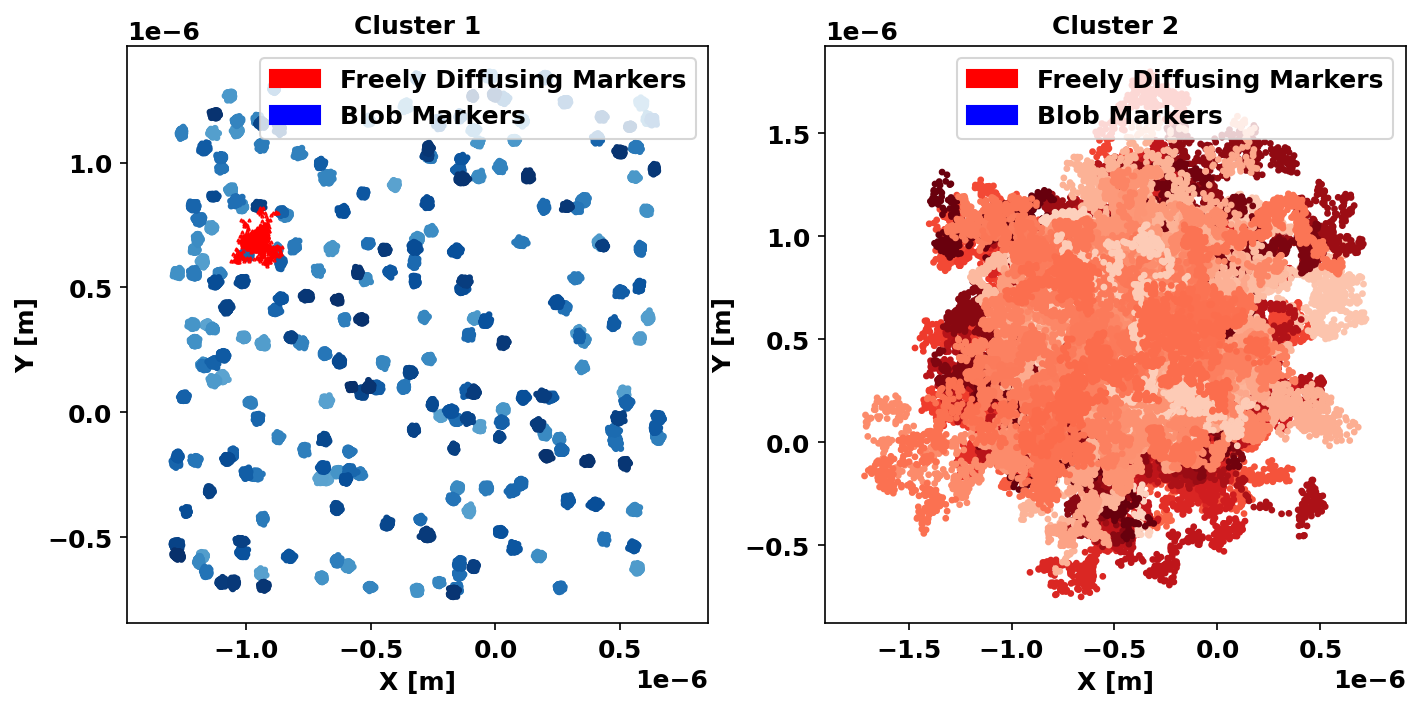

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('default')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

if task_list[0].dimension == 2:
    fig, axs = plt.subplots(1,2, figsize=(11,5), dpi = 150)
    img1 = axs[0].scatter(*zip(*np.row_stack([task.pointCloud for task in cluster_1 if task.ID in blob_ID])), 
                          c = np.concatenate([np.full(shape = len(task.pointCloud), fill_value = task.ID) for task in cluster_1 if task.ID in blob_ID]), 
                          s = 5, cmap  = 'Blues', vmin = -50)

    try:
        ## This is a hack to highlight the only track that is misclassified. Just uncomment the code below if you use it for your own sake.
        axs[0].scatter(*zip(*np.row_stack([task.pointCloud for task in cluster_1 if task.ID not in blob_ID])), marker = '^', c = 'red', s = 1)
        #                c = np.concatenate([np.full(shape = len(task.pointCloud), fill_value = task.ID) for task in cluster_1 if task.ID not in blob_ID]), 
        #                s = 1, cmap = 'Reds', vmin = -50)
    except:
        pass

    img2 = axs[1].scatter(*zip(*np.row_stack([task.pointCloud for task in cluster_2 if task.ID in free_ID])), 
                          c = np.concatenate([np.full(shape = len(task.pointCloud), fill_value = task.ID) for task in cluster_2 if task.ID in free_ID]), 
                          s = 5, cmap = 'Reds', vmin = -50)

    try:
        axs[1].scatter(*zip(*np.row_stack([task.pointCloud for task in cluster_2 if task.ID not in free_ID])), marker = '^', 
                       c = np.concatenate([np.full(shape = len(task.pointCloud), fill_value = task.ID) for task in cluster_2 if task.ID not in free_ID]), 
                       s = 3, cmap = 'Blues', vmin = -50)
    except:
        pass
    
    axs[0].axis('equal')
    axs[1].axis('equal')
    
    axs[0].set_xlabel('X [m]', fontsize = 12, fontweight = 'bold')
    axs[0].set_ylabel('Y [m]', fontsize = 12, fontweight = 'bold')
    axs[0].set_title('Cluster 1', fontsize = 12, fontweight = 'bold')

    axs[1].set_xlabel('X [m]', fontsize = 12, fontweight = 'bold')
    axs[1].set_ylabel('Y [m]', fontsize = 12, fontweight = 'bold')
    axs[1].set_title('Cluster 2', fontsize = 12, fontweight = 'bold')
    
    red_patch = mpatches.Patch(color='red', label='Freely Diffusing Markers')
    blue_patch = mpatches.Patch(color='blue', label='Blob Markers')


    axs[0].legend(handles=[red_patch, blue_patch], loc = 'upper right', fontsize = 12)
    axs[1].legend(handles=[red_patch, blue_patch],  loc = 'upper right', fontsize = 12)

if task_list[0].dimension == 3:
    fig, axs = plt.subplots(1,2, figsize=(11,5), dpi = 250,subplot_kw={'projection': '3d'})
    img1 = axs[0].scatter3D(*zip(*np.row_stack([task.pointCloud for task in cluster_1 if task.ID in blob_ID])),
                          c = np.concatenate([np.full(shape = len(task.pointCloud), fill_value = task.ID) for task in cluster_1 if task.ID in blob_ID]), 
                          s = 5, cmap  = 'Blues', vmin = -50,
                          alpha = 0.4)
    try:
        axs[0].scatter3D(*zip(*np.row_stack([task.pointCloud for task in cluster_1 if task.ID not in blob_ID])), marker = '^', 
                          c = np.concatenate([np.full(shape = len(task.pointCloud), fill_value = task.ID) for task in cluster_1 if task.ID not in blob_ID]), 
                          s = 1, cmap = 'Reds', vmin = -50,
                          alpha = 0.4)
    except:
        pass

    img2 = axs[1].scatter3D(*zip(*np.row_stack([task.pointCloud for task in cluster_2 if task.ID in free_ID])), 
                          c = np.concatenate([np.full(shape = len(task.pointCloud), fill_value = task.ID) for task in cluster_2 if task.ID in free_ID]), 
                          s = 5, cmap = 'Reds', vmin = -50,
                          alpha = 0.4)

    try:
        axs[1].scatter3D(*zip(*np.row_stack([task.pointCloud for task in cluster_2 if task.ID not in free_ID])), marker = '^', 
                          c = np.concatenate([np.full(shape = len(task.pointCloud), fill_value = task.ID) for task in cluster_2 if task.ID not in free_ID]), 
                          s = 3, cmap = 'Blues', vmin = -50,
                          alpha = 0.4)
    except:
        pass
    
    red_patch = mpatches.Patch(color='red', label='Freely Diffusing Markers')
    blue_patch = mpatches.Patch(color='blue', label='Blob Markers')

    axs[0].set_xlabel('X [m]', fontsize = 12, fontweight = 'bold')
    axs[0].set_ylabel('Y [m]', fontsize = 12, fontweight = 'bold')
    axs[0].set_zlabel('Z [m]', fontsize = 12, fontweight = 'bold')
    axs[0].set_title('Cluster 1', fontsize = 12, fontweight = 'bold')

    axs[1].set_xlabel('X [m]', fontsize = 12, fontweight = 'bold')
    axs[1].set_ylabel('Y [m]', fontsize = 12, fontweight = 'bold')
    axs[1].set_zlabel('Z [m]', fontsize = 12, fontweight = 'bold')
    axs[1].set_title('Cluster 2', fontsize = 12, fontweight = 'bold')

    axs[0].legend(handles=[red_patch, blue_patch], loc = 'upper center', fontsize = 12)
    axs[1].legend(handles=[red_patch, blue_patch],  loc = 'upper center', fontsize = 12)
    


### That looks pretty good. We have successfully separated blobs and freely moving markers.

---------------------------------------------------------------------------------------------------------

### Here is a compiled version of the code above:
(You can find this standalon version in the `__init__.py`. Just use `from blolBgone import BlobBGone` to access the function.)

In [11]:
### DISCLAIMER ###
## For reproducibility, we use the same random seed for the clustering algorithm here. The standalone version in __init__.py does not use a random seed. ##


def BlobBGone(path:str = None, return_IDs:bool = False, regularization_method:str = 'standardize', verbose:bool = True):
    """Standalone implementation of the Blob-B-Gone method for removing blobs from Single Particle Tracking data.

    Args:
        path (str, optional): Indicate the path to the directory containing the data files as .npy with the format [Z,Y,X,T]. Defaults to None.
        return_IDs (bool, optional): Flag if you want to merely return the IDs of tracks belonging to either cluster. Defaults to False.
        regularization_method (str, optional): Flag the method to be used for regularization from ['standardize', 'force_raw']. Defaults to 'standardize'.
        verbose (bool, optional): Flag the verbosity while clustering. Defaults to True.

    Returns:
        blobs, free (featureHandler or int): Returns either the feature handler objects of the two clusters or the IDs of the two clusters.
    """
    import os
    import numpy as np
    from sklearn.cluster import KMeans
    from sklearn import metrics
    from blobBgone.featureHandler import featureHandler
    
    # Grab the files
    files = featureHandler.grab_files(path = None)
    if verbose:
        print(f"Found {len(files)} files in the '{files[0].split(os.sep)[-2]}' directory.")
        
    # Setup the task list
    task_list = [featureHandler.from_npy(path = file, verbose = False) for file in files]
    
    if verbose:
        print("\nExtracting features...")
    # Extract features
    features = []
    for task in task_list:
        task.extract()
        features.append(task.to_array())

    # Regularize the features
    features = featureHandler.regularize_output(features, method = regularization_method)
    assert np.all(np.isfinite(features)), "NaN values still present in features."


    if verbose:
        print("\nClustering...")
    # Cluster the features
    clustering_FH  = KMeans(
        n_clusters = 2,
        init = 'k-means++',
        n_init = 'auto',
        max_iter = 300,
        verbose = 0,
        random_state = 42, ## Here, we set the random state to 42 for reproducibility
        )
    fit_predict_FH = clustering_FH.fit_predict(features)
    
    cluster_1 = [task_list[i] for i in range(len(task_list)) if fit_predict_FH[i] == 0]
    cluster_2 = [task_list[i] for i in range(len(task_list)) if fit_predict_FH[i] == 1]
    comb = [cluster_1, cluster_2]
    
    ## Evaluate Blobbness ##
    # this is an experimental metric that attempts to decide what cluster is the blob cluster
    if verbose:
        print("\nBlob-score is being calculated...\n")
    c1_blobbness = np.mean([task.features.SPHE/task.features.MAX_DIST for task in cluster_1])
    c2_blobbness = np.mean([task.features.SPHE/task.features.MAX_DIST for task in cluster_2])
    if verbose:
        print("Cluster 1 Blob-score: {:.2f}".format(c1_blobbness))
        print("Cluster 2 Blob-score: {:.2f}".format(c2_blobbness))
        print("Blob-score ratio: 1 : {:.2f}".format(max([c1_blobbness, c2_blobbness])/min([c1_blobbness, c2_blobbness])))
        print(
            "Silhouette Coefficient: %0.3f"
            % metrics.silhouette_score(features, fit_predict_FH, metric="euclidean")
        )
        
        print("\nCluster {} has been estimated to be the blob cluster.".format(np.argmax([c1_blobbness, c2_blobbness])+1))

    if not return_IDs:
        blobs = [task for task in comb[np.argmax([c1_blobbness, c2_blobbness])]]
        free =  [task for task in comb[np.argmin([c1_blobbness, c2_blobbness])]]
        return blobs, free

    blobs = [task.ID for task in comb[np.argmax([c1_blobbness, c2_blobbness])]]
    free =  [task.ID for task in comb[np.argmin([c1_blobbness, c2_blobbness])]]
    return blobs, free

In [12]:
## Let's try it out ##
blobs, free = BlobBGone(path = None, return_IDs = False, regularization_method = 'standardize', verbose = True)

Found 500 files in the 'C:/Users/belav/Documents/GitHub/blob-B-gone/Example_Data/Simulation/2D_Mix_dynamicSTD' directory.

Extracting features...

Clustering...

Blob-score is being calculated...

Cluster 1 Blob-score: 132495540.13
Cluster 2 Blob-score: 3579088.29
Blob-score ratio: 1 : 37.02
Silhouette Coefficient: 0.712

Cluster 1 has been estimated to be the blob cluster.


In [13]:
blobs[0]

Feature Handler (ID = 250, dimension = 2, length = 600)

Features in place.
 - features2D(MAX_DIST=4.388042835003813e-08, CV_AREA=1.0441542346180427e-15, SPHE=6.406863793734763, ELLI=1.0516210675843836, CV_DENSITY=5.746277514446736e+17)


 
      -------------------------------------- 

 - To get an array of features call featureHandler.to_array()
 - To get a dict of features call featureHandler.to_dict()

Suspected Artifactual Marker (Blob)

------------------------------



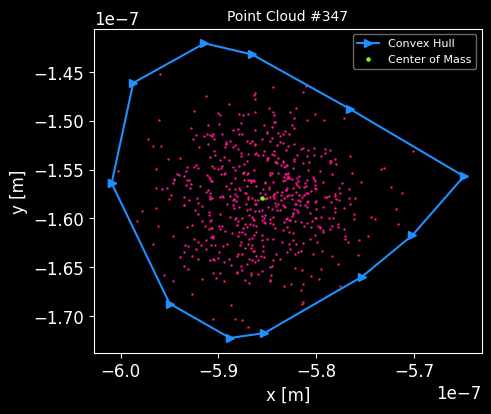

Suspected Free Marker

------------------------------



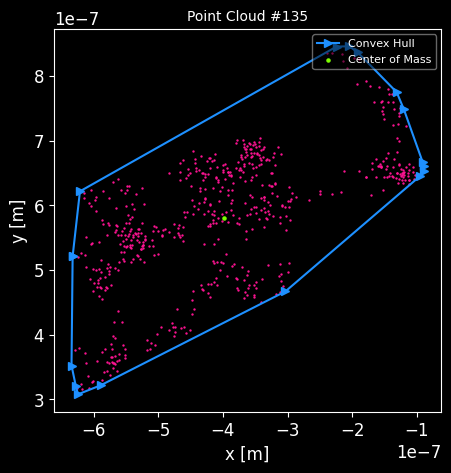

In [14]:
## Seeing is believing ##
import numpy as np
print("Suspected Artifactual Marker (Blob)")
print("\n------------------------------\n")
blobs[np.random.randint(0,len(blobs))].overview()

print("Suspected Free Marker")
print("\n------------------------------\n")
free[np.random.randint(0,len(free))].overview()